# Car price prediction


>The aim of this project is to build a model for car price estimation.<br>
The model is supposed to be used in application for quick market price determination. Thus, prediction quality, prediction time, and training time are important. <br>
The training data is a set of records with car characteristics and prices, as well as some user data from different countries. 


## Preliminary data processing

In [1]:
#importing libraries
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor
import sklearn.metrics

import numpy as np

from lightgbm import LGBMRegressor

In [2]:
#file uploading
try:
    data = pd.read_csv('/datasets/autos.csv')
    print('Using cloud files')
    print()
except:
    data = pd.read_csv('D:/Bot/DataScience/Jupyter projects/3 module/project 2/autos.csv')
    print('Using local files')
    print()

Using local files



In [3]:
#data overview
display(data.head())
display(data.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

Gaps are present along with wrong data types. Date and time records were written like objects. 

### Duplicate search


In [4]:
#firstly bring all strings to lowercase
strings = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
for element in strings:
    data[element] = data[element].str.lower()

print(data.duplicated().sum())

4


In [5]:
#delete duplicates
data = data.drop_duplicates().reset_index(drop=True)
print(data.duplicated().sum())

0


### Changing data types

In [6]:
#convert columns with dates to datetime
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'],format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'],format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'],format='%Y-%m-%d %H:%M:%S')

### Handling missing data

In [7]:
#printing gaps info
print('Percentage of missing values:')   
display(data.isnull().sum()*100/len(data)) #this is to show % of all data

Percentage of missing values:


DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579487
RegistrationYear      0.000000
Gearbox               5.596772
Power                 0.000000
Model                 5.560651
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282802
Brand                 0.000000
NotRepaired          20.079297
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

#### Gearbox


As a gearbox is an option its not possible to restore data from the model. We can try to fill in hybrids and electro cars with automated gearboxes.


In [8]:
print('How many gaps we fill:')
print(data.query('(FuelType == "electric")|(FuelType == "hybrid")')['Gearbox'].isna().sum())
data.loc[(data['FuelType']=="electric")|(data['FuelType']=="hybrid")]['Gearbox'].fillna('auto')

How many gaps we fill:
18


1075        auto
3244      manual
4724        auto
5119        auto
5307        auto
           ...  
349200      auto
350122      auto
350566      auto
352032      auto
352460    manual
Name: Gearbox, Length: 323, dtype: object

In [9]:
#fill in the gaps with marker values
data['Gearbox'] = data['Gearbox'].fillna('unknown')

#### Model

In [10]:
#deleting missing records
data = data.dropna(subset=['Model'])
#browsing rest names just in case
print(data['Model'].sort_values().unique())

['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g_klasse' 'galant'
 'galaxy' 'getz' 'gl' 'glk' 'golf' 'grand' 'i3' 'i_reihe' 'ibiza'
 'impreza' '

#### Fuel, repair and body style

Fill in the gaps with marker values

In [11]:
data['FuelType'] = data['FuelType'].fillna('unknown')
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')
data['VehicleType'] = data['VehicleType'].fillna('unknown')

### Check-up


In [12]:
print('Percentage of missing values:')  
display(data.isnull().sum()*100/len(data))

Percentage of missing values:


DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

### Search of errors and values improvement


In [13]:
#owerview of numerical data
display(data.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,334660.000000,334660.000000,334660.000000,334660.000000,334660.000000,334660.0,334660.000000
mean,4504.372249,2003.924024,111.372659,128562.795076,5.806075,0.0,50671.327365
std,4531.457109,69.377633,185.157391,37205.638630,3.689157,0.0,25754.527341
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1150.000000,1999.000000,70.000000,125000.000000,3.000000,0.0,30419.000000
50%,2800.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49525.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


There are problems with power, registration year and driven distance (like its limit is 150k kilometres). 0th registration month is also an error. Zero pictures are in the base.  

#### Registration month

In [14]:
#how many incorrect records for month
print('Unique values of monthes number')
print(data['RegistrationMonth'].sort_values().unique())
zeros = data.query('RegistrationMonth == 0')['RegistrationMonth'].count()
print('0 values in total:',zeros,',', 'as a % of the total:',zeros/len(data)*100,'%')

Unique values of monthes number
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
0 values in total: 30810 , as a % of the total: 9.206358692404232 %


In [15]:
#checking percentage of the total for each month number 
print('Rate of each month in total data')
display(data['RegistrationMonth'].value_counts(normalize=True))

Rate of each month in total data


3     0.098894
0     0.092064
6     0.089957
4     0.083619
5     0.083228
7     0.077574
10    0.075022
11    0.069689
12    0.069569
9     0.068658
1     0.065894
8     0.064818
2     0.061014
Name: RegistrationMonth, dtype: float64

The amount of incorrect data is very high for deletion, and its hard to figure out a logical replacement for them. 

In [16]:
#convert to another data type to process with one-hot encoding method
data['RegistrationMonth'] = data['RegistrationMonth'].astype('str')
display(data['RegistrationMonth'].describe())

count     334660
unique        13
top            3
freq       33096
Name: RegistrationMonth, dtype: object

#### Registration year

In [17]:
#browsing for incorrect registrations year values
print(data['RegistrationYear'].sort_values().unique())
#since 1910(Wiki) 
wrong = data[(data['RegistrationYear']<1910)|(data['RegistrationYear']>2019)]['RegistrationYear'].count()
print()
print('Total amount of incorrect records:',wrong)
#deleting
data = data.query('(RegistrationYear > 1909)&(RegistrationYear <2020)')


[1000 1001 1111 1200 1234 1300 1400 1500 1600 1602 1800 1910 1919 1923
 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1941 1942
 1943 1945 1947 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959
 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2066 2200 2290 2500 2900 3000 3700 4000 4500 5000
 5555 5900 5911 6000 6500 7000 7100 7500 7800 8000 8200 8500 9000 9999]

Total amount of incorrect records: 96


If we check last users activity, which is data['LastSeen'].max(), we can find out latest possible registration year.

In [18]:
display(data['LastSeen'].max())
data = data.query('RegistrationYear <=2016')

Timestamp('2016-04-07 14:58:51')

In [19]:
print(data['RegistrationYear'].sort_values().unique()) #checking

[1910 1919 1923 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937
 1938 1941 1942 1943 1945 1947 1949 1950 1951 1952 1953 1954 1955 1956
 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016]


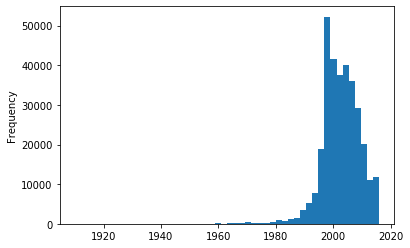

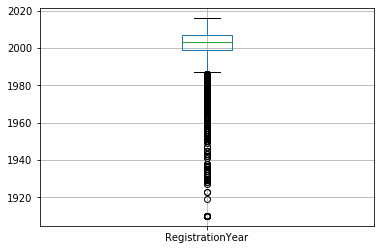

In [20]:
data['RegistrationYear'].plot(kind = 'hist',bins = 50)
plt.show()
data.boxplot('RegistrationYear')
plt.show()


#### Driven distance

Unique values of the driven distance: [  5000  10000  20000  30000  40000  50000  60000  70000  80000  90000
 100000 125000 150000]


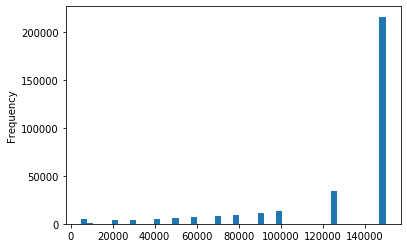

In [21]:
print('Unique values of the driven distance:',data['Kilometer'].sort_values().unique())
data['Kilometer'].plot(kind = 'hist',bins = 50)
plt.show()

In [22]:
#correlation of driven distance and registration year 
print(data['Kilometer'].corr(data['RegistrationYear']))

-0.2455009347912855


#### Power

overpowered: 82
bicycle: 30886


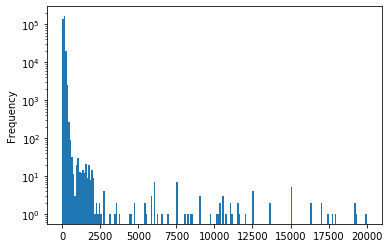

In [23]:
#print(data['Power'].sort_values().unique()) #too long list
data['Power'].plot(kind='hist', bins=200)
plt.yscale('log')
#how many records are bigger than 2,5k?
overpowered = data.query('Power > 2500')['Power'].count()
print('overpowered:',overpowered)
bicycle = data.query('Power == 0')['Power'].count()
print('bicycle:',bicycle)
data = data.query('Power <=2500') #removing anomalies

Seems, that a lot of cars got wrong near-zero powers. Will try to improve that. 

In [24]:
#power spectrum for each model exclusive of 0-powered
#for median value
power_spectrum = data.query('Power !=0').pivot_table(index=['Brand','Model','VehicleType'],values='Power',aggfunc='median')

display(power_spectrum)   


Power
Brand      Model    VehicleType       
alfa_romeo 145      coupe        103.0
                    other        100.0
                    sedan        111.0
                    small        103.0
                    unknown      103.5
...                                ...
volvo      v70      wagon        163.0
           xc_reihe sedan        160.0
                    suv          185.0
                    unknown      185.0
                    wagon        185.0

[1612 rows x 1 columns]

In [25]:
#how many records with very low powers? 
rest_bicycles = data.query('Power <=15')['Power'].count()
print('rest bicycles:',rest_bicycles)
#lets process also overpowered 
rest_overpowered = data.query('Power >= 1000')['Power'].count()
print('rest overpowered:',rest_overpowered)

rest bicycles: 31011
rest overpowered: 168


In [26]:
#function for the row which substitutes values bove and below the threshhold
#with median values from the power spectrum table
def power2(row):
    power = row['Power'] 
    brand = row['Brand']
    model = row['Model']
    body = row['VehicleType']
    new_power = power
    if model != 'serie_1':
        if (power <= 15)|(power >= 1000): #убираем также и очень большие значения
            try:
                new_power = power_spectrum.loc[(brand, model, body)].iloc[0]
            except:
                new_power = power
    return new_power

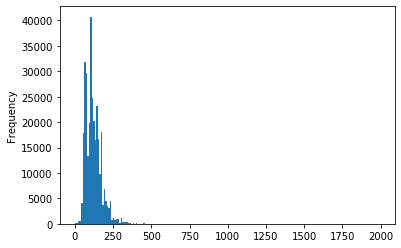

Wall time: 16.6 s


In [27]:
%%time
#using the function
data['Power'] = data.apply(power2, axis = 1)
data['Power'].plot(kind='hist', bins=200)
plt.show()

The distribution has improved.

In [28]:
#examine rest low-powered and overpowered cars
print('rest bicycles:',data.query('Power <=15')['Power'].count())
print('rest overpowered:',data.query('Power >= 1000')['Power'].count())
print()
print('Power info:')
display(data['Power'].describe())

rest bicycles: 181
rest overpowered: 3

Power info:


count    322062.000000
mean        119.203434
std          53.779644
min           0.000000
25%          75.000000
50%         110.000000
75%         145.000000
max        1992.000000
Name: Power, dtype: float64

The rest is negligible.

#### Categories

In [29]:
#display unique categories
for element in strings:
    print(str(element + ':'))
    print(data[element].sort_values().unique())

VehicleType:
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'unknown'
 'wagon']
Gearbox:
['auto' 'manual' 'unknown']
Model:
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour'

Seems everything is ok.

#### Pictures

In [30]:
display(data['NumberOfPictures'].describe())

count    322062.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

Everything is zero, deleting that.

In [31]:
data = data.drop('NumberOfPictures',axis=1)

#### Postal code

In [32]:
print('Unique codes:')
display(len(data['PostalCode'].unique()))

Unique codes:


8128

For representation of territory dependence 2 first code digits will be kept.

In [33]:
def truncate(number):
    string = str(number)
    new = string[:2]
    return new
data['PostalCode'] = data['PostalCode'].apply(truncate)
    

In [34]:
display(data['PostalCode'].describe())
print('Unique prefixes:',len(data['PostalCode'].unique()))

count     322062
unique        90
top           45
freq        7820
Name: PostalCode, dtype: object

Unique prefixes: 90


### Data analysis

In [35]:
#review of correlation table
data.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.465312,0.485615,-0.356504
RegistrationYear,0.465312,1.000000,0.128314,-0.245562
Power,0.485615,0.128314,1.000000,0.096837
Kilometer,-0.356504,-0.245562,0.096837,1.000000


Checking target.

In [36]:
display(data['Price'].describe())
#how many records are for outgiving
print('Outgiving:',data.query('Price==0')['Price'].count(),'%:',100*data.query('Price==0')['Price'].count()/len(data))

count    322062.000000
mean       4556.022719
std        4560.708670
min           0.000000
25%        1150.000000
50%        2899.000000
75%        6550.000000
max       20000.000000
Name: Price, dtype: float64

Outgiving: 8016 %: 2.488961752706001


One can observe strange Price values. However, it is not yet clear what leads to this result, and should be discussed with client.

#### Categosizing car age

In [37]:
#creating Age feature
data['Age'] = 2016 - data['RegistrationYear']
#grouping by age
price_by_age = data.pivot_table(index='Age',values='Price',aggfunc='median')
display(price_by_age.head())


,Price
Age,
0,980.0
1,13500.0
2,13864.5
3,12900.0
4,11800.0


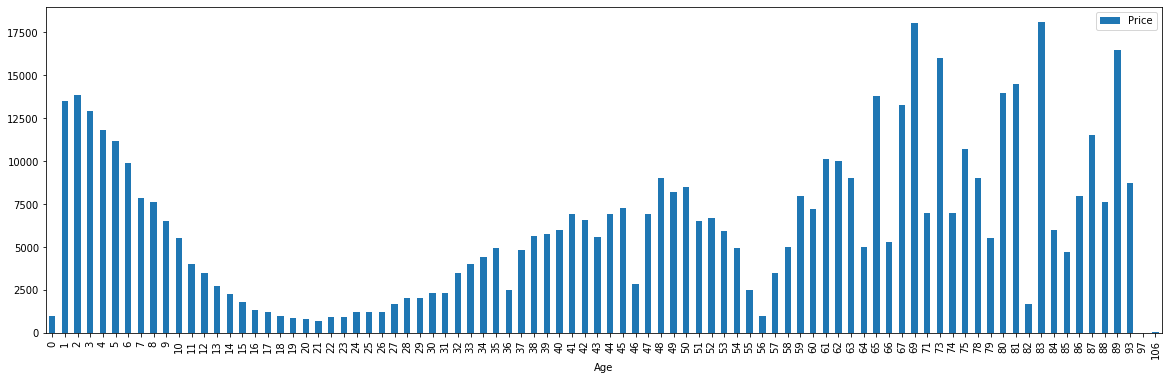

In [38]:
#cheking out relationship between average price and age
price_by_age.plot(kind='bar',figsize=(20,6))
plt.show()
#removing 2016 years data as they are incomplete
data = data.query('RegistrationYear <2016')

One should try the following  intervals: 0-6, 7-10, 11-20, 21-30, 31-55, 56-100.

In [39]:
#function for creation age category
def age_group(age):
    age_group = None
    if age <=6:
        age_group = 'young'
    elif 7 < age <= 10:
        age_group = 'medium'
    elif 11 < age <= 20:
        age_group = 'aged'
    elif 21 < age <= 30:
        age_group = 'classic'
    elif 31 < age <= 55:
        age_group = 'antique'
    else:
        age_group = 'vintage'
    return age_group

In [40]:
#adding Age feature
data['age_group'] = data['Age'].apply(age_group)
display(data['age_group'].unique())

array(['classic', 'aged', 'medium', 'vintage', 'antique', 'young'],
      dtype=object)

## Model trainig

### Features processing

Applying one-hot encoding to non-numeric data. As we duplicated registration year with age, one should be deleted. We keep the age.

In [41]:
%%time
#deleting useless timestamps
data = data.drop(['DateCrawled','LastSeen','DateCreated','RegistrationYear'],axis=1)
data_ohe = pd.get_dummies(data, drop_first=True)
display(data_ohe.head())

,Price,Power,Kilometer,Age,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,PostalCode_95,PostalCode_96,PostalCode_97,PostalCode_98,PostalCode_99,age_group_antique,age_group_classic,age_group_medium,age_group_vintage,age_group_young
0,480,90.0,150000,23,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,9800,163.0,125000,12,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1500,75.0,150000,15,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3600,69.0,90000,8,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,650,102.0,150000,21,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


Wall time: 983 ms


### Splitting data

In [42]:
#splitting data into target and features
target_ohe = data_ohe['Price']

#removing target from features 
#as well as useless dates
features_ohe = data_ohe.drop(['Price'],axis=1) 
features = data.drop(['Price'],axis=1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe,target_ohe,test_size=0.25,random_state=12345)


In [43]:
#checking subsets sizes
print(features_train_ohe.shape)
print(features_test_ohe.shape)
print(target_train_ohe.shape)
print(target_test_ohe.shape)

(235332, 415)
(78444, 415)
(235332,)
(78444,)


### Models


In [44]:
#accessory function for feature importance bar charts

def importance_plot(model,start,stop): #model name, start and end numbers of features in descending order
    #from feature_importances for model we make Series,where indexes = features names
    model_importance = pd.Series(model.feature_importances_,index=features_train_ohe.columns) 
    #sor descending, slicing by start-stop numbers
    model_imp = model_importance.sort_values(ascending=False)[start:stop]
    fig, ax = plt.subplots(figsize=(12,10))
    model_imp.plot.bar()
    ax.set_title("Feature importances")
    fig.tight_layout()

In [45]:
#accessory function for chosing certain amount of features in descending order of feature importance
def importance_filter(model,num_features):
    model_importance = pd.Series(model.feature_importances_,index=features_train_ohe.columns)
    model_imp = model_importance.sort_values(ascending=False)[:num_features]
    return model_imp.index

#### Linear regression

In [46]:
%%time
model1 = linear_model.LinearRegression()
lin1_scores = (-cross_val_score(model1, features_train_ohe, target_train_ohe,scoring='neg_mean_squared_error', cv=5))**0.5
rmse_lin1 = lin1_scores.max()
print('RMSE of cross-validation:',lin1_scores)
print('worst RMSE of cross-validation:',rmse_lin1)

RMSE of cross-validation: [2311.43031018 2287.75045654 2295.98239455 2307.42763836 2300.82131614]
worst RMSE of cross-validation: 2311.4303101832465
Wall time: 20 s


In [47]:
%%time
#training model 
model1.fit(features_train_ohe, target_train_ohe)

Wall time: 4.55 s


LinearRegression()

In [48]:
%%time
#getting predictions on test
predictions1 = model1.predict(features_test_ohe)
rmse_lin1_test = mean_squared_error(target_test_ohe,predictions1)**0.5
print('test RMSE:',rmse_lin1_test)

test RMSE: 2299.11765571419
Wall time: 148 ms


#### Decision tree

In [49]:
%%time 
#using GridSearchCV from sklearn we go over set of parameters

parameters_tree = {
    
    'max_depth':[2,12],
       
}
model2 = DecisionTreeRegressor(random_state=12345)
gsearch_1 = GridSearchCV(model2,parameters_tree,scoring='neg_mean_squared_error',n_jobs=-1,cv=5)
gsearch_1.fit(features_train_ohe,target_train_ohe)
print(gsearch_1.best_params_)

{'max_depth': 12}
Wall time: 28.8 s


In [50]:
%%time
tree2_scores = (-cross_val_score(gsearch_1.best_estimator_, features_train_ohe, target_train_ohe,scoring='neg_mean_squared_error', cv=5))**0.5
rmse_tree2 = tree2_scores.max()
print('RMSE of cross-validation:',tree2_scores)
print('worst RMSE of cross-validation:',rmse_tree2)

RMSE of cross-validation: [2013.94453829 2019.75300977 1985.99827422 2018.94262111 2006.01526495]
worst RMSE of cross-validation: 2019.7530097697625
Wall time: 37.1 s


In [51]:
%%time
#checking learning time on train 

model_tree_test = DecisionTreeRegressor(max_depth=12,random_state=12345)
model_tree_test.fit(features_train_ohe,target_train_ohe)

Wall time: 9.16 s


DecisionTreeRegressor(max_depth=12, random_state=12345)

In [52]:
%%time
#getting predictions of the best model on test
predictions2 = gsearch_1.best_estimator_.predict(features_test_ohe)
rmse_tree2_test = mean_squared_error(target_test_ohe,predictions2)**0.5
print('RMSE on test:',rmse_tree2_test)

RMSE on test: 1998.2441488356149
Wall time: 218 ms


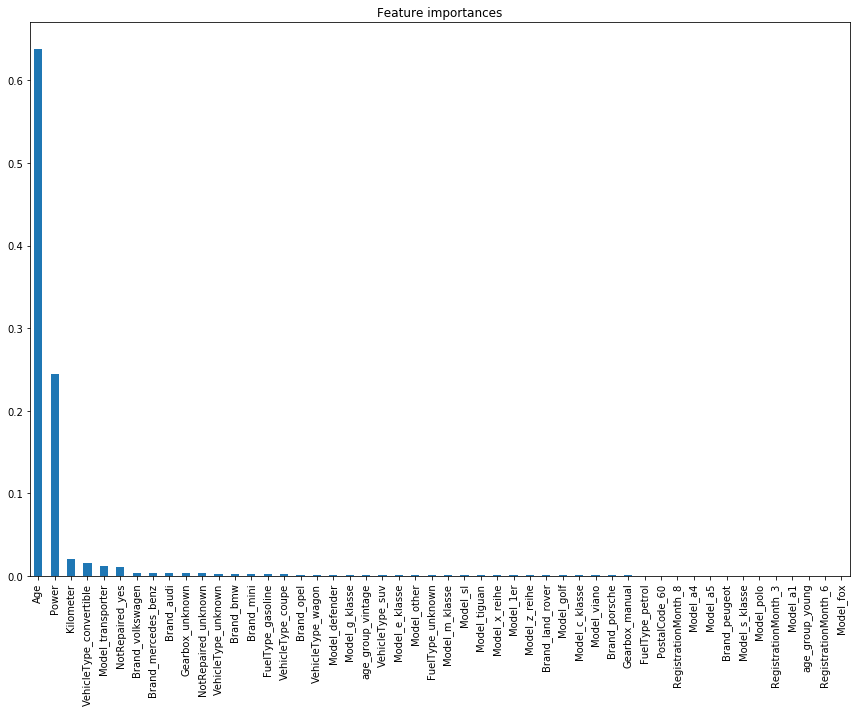

In [53]:
#can we reduce learning time if we omit unimportant features

importance_plot(gsearch_1.best_estimator_,0,50)

In [54]:
#making sorted features list of desired lenght
filtered_features_tree = importance_filter(gsearch_1.best_estimator_,45) 
features_train_tree_imp = features_train_ohe[filtered_features_tree]
print(features_train_tree_imp.shape)

(235332, 45)


In [55]:
%%time
model3 = DecisionTreeRegressor(max_depth = 12, random_state=12345)
tree3_scores = (-cross_val_score(model3, features_train_tree_imp, target_train_ohe,scoring='neg_mean_squared_error', cv=5))**0.5
rmse_tree3 = tree3_scores.max()
print('RMSE of cross-validation:',tree3_scores)
print('worst RMSE of cross-validation:',rmse_tree3)

RMSE of cross-validation: [2016.73063251 2012.59753722 1970.82867528 2010.84655406 2007.12554136]
worst RMSE of cross-validation: 2016.7306325115223
Wall time: 5.65 s


In [56]:
%%time
features_test_tree_imp = features_test_ohe[filtered_features_tree]
model3.fit(features_train_tree_imp, target_train_ohe)
predictions3 = model3.predict(features_test_tree_imp)
rmse_tree3_test = mean_squared_error(target_test_ohe,predictions3)**0.5
print('RMSE on test:',rmse_tree3_test)

RMSE on test: 1986.6936625825783
Wall time: 1.33 s


#### Gradient boosting

In [57]:
%%time
model6 = LGBMRegressor(random_state = 12345)
parameters_LGBMR = {
    'boosting_type':('gbdt','dart','goss'),
    'max_depth':[5,40],
    'num_leaves':[5,30]  
}
gsearch_2 = GridSearchCV(model6,parameters_LGBMR,scoring='neg_mean_squared_error',n_jobs=-1,cv=5)
gsearch_2.fit(features_train_ohe,target_train_ohe)
print(gsearch_2.best_params_)

{'boosting_type': 'goss', 'max_depth': 40, 'num_leaves': 30}
Wall time: 1min 39s


In [58]:
rmse_lgbmr6 = (-gsearch_2.best_score_)**0.5
print('RMSE of the best model:',rmse_lgbmr6)

RMSE of the best model: 1748.2346292366985


In [59]:
%%time
#получение предсказаний на тестовой выборке
predictions6 = gsearch_2.best_estimator_.predict(features_test_ohe)
rmse_lgbmr6_test = mean_squared_error(target_test_ohe,predictions6)**0.5
print('RMSE on test:',rmse_lgbmr6_test)

RMSE on test: 1747.0392894065405
Wall time: 518 ms


In [60]:
%%time
#проверим время обучения модели с уже известными параметрами
test_model = gsearch_2.best_estimator_
test_model.fit(features_train_ohe,target_train_ohe)

Wall time: 3.3 s


LGBMRegressor(boosting_type='goss', max_depth=40, num_leaves=30,
              random_state=12345)

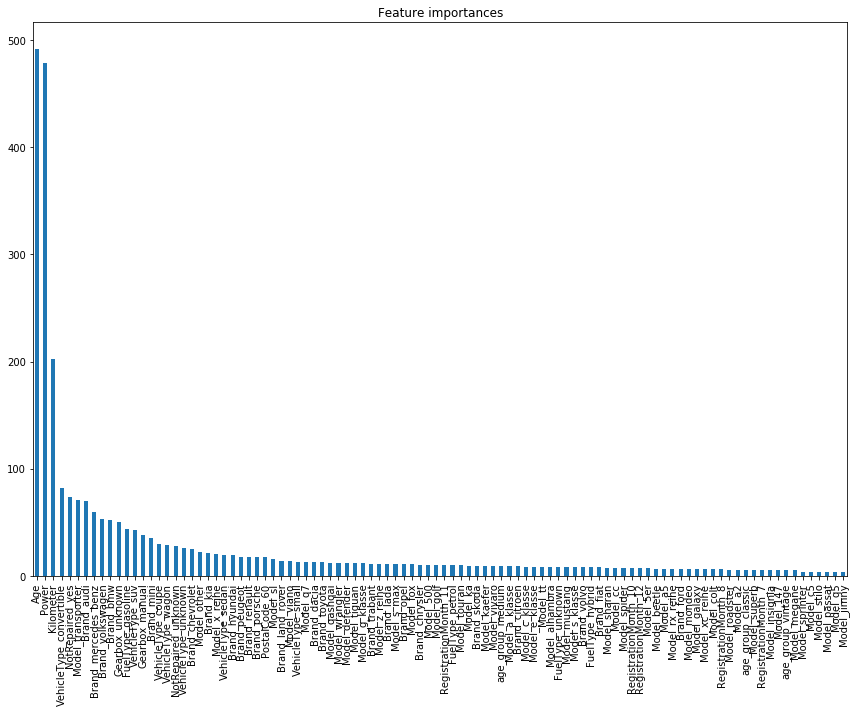

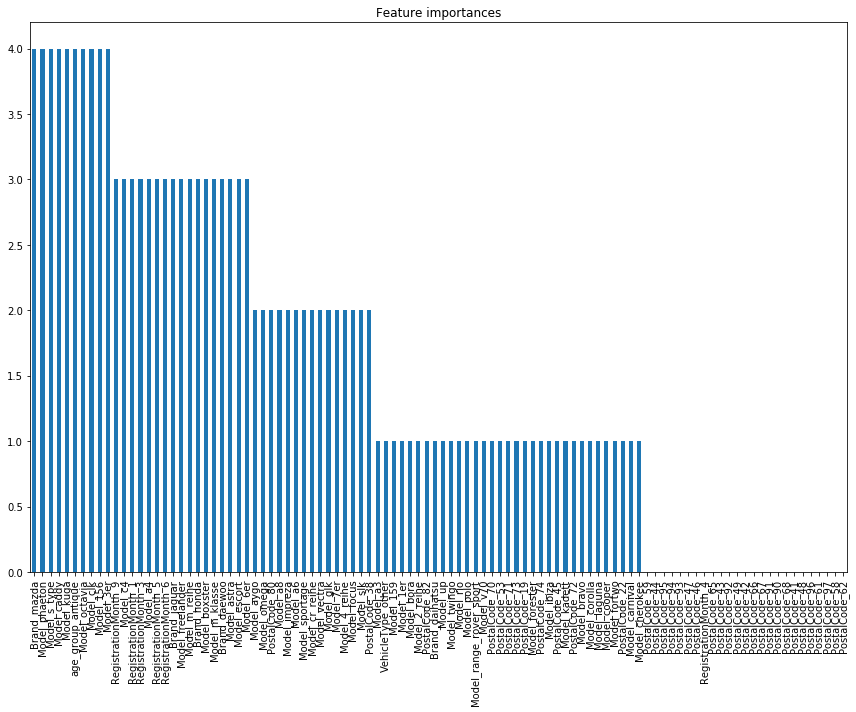

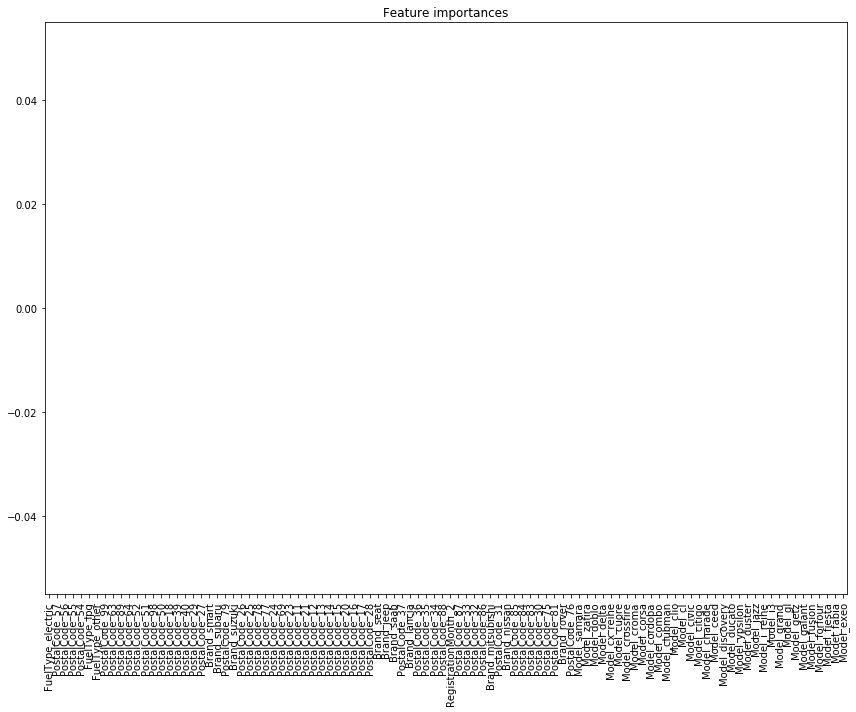

In [61]:
#попытаемся избавиться от лишних признаков, чтобы уменьшить время обучения и предсказания
importance_plot(gsearch_2.best_estimator_,0,100)
importance_plot(gsearch_2.best_estimator_,100,200)
importance_plot(gsearch_2.best_estimator_,200,300)

In [62]:
#cоздаем отсортированный список фич нужной длины
filtered_features_lgbmr = importance_filter(gsearch_2.best_estimator_,180) 
features_train_lgbmr_imp = features_train_ohe[filtered_features_lgbmr]
print(features_train_lgbmr_imp.shape)

(235332, 180)


In [63]:
%%time
model7 = LGBMRegressor(boosting_type='goss', max_depth = 40, num_leaves=30,random_state = 12345)
lgbmr_scores = (-cross_val_score(model7, features_train_lgbmr_imp, target_train_ohe,scoring='neg_mean_squared_error', cv=5))**0.5
rmse_lgbmr7 = lgbmr_scores.max()
print('RMSE on cross-validation:',lgbmr_scores)
print('worst RMSE on cross-validation:',rmse_lgbmr7)


RMSE on cross-validation: [1758.15228591 1754.11020278 1722.30487258 1755.00614621 1758.63277954]
worst RMSE on cross-validation: 1758.632779535748
Wall time: 12.8 s


In [64]:
%%time
#training model
features_test_lgbmr_imp = features_test_ohe[filtered_features_lgbmr]
model7.fit(features_train_lgbmr_imp, target_train_ohe)


Wall time: 2.42 s


LGBMRegressor(boosting_type='goss', max_depth=40, num_leaves=30,
              random_state=12345)

In [65]:
%%time
#getting predictions time
predictions7 = model7.predict(features_test_lgbmr_imp)
rmse_lgbmr7_test = mean_squared_error(target_test_ohe,predictions7)**0.5
print('RMSE on test:',rmse_lgbmr7_test)

RMSE on test: 1748.6968805381819
Wall time: 327 ms



#### Comparison with dummy models

In [66]:
#compare model predictions with median prediction of brand/model/body type

#using slightly modified function for power replacement
prices = data.pivot_table(index=['Brand','Model','VehicleType'],values='Price',aggfunc='median')
display(prices)

Price
Brand      Model    VehicleType         
alfa_romeo 145      coupe          600.0
                    other          500.0
                    sedan          880.0
                    small          600.0
                    unknown        100.0
...                                  ...
volvo      v70      wagon         2800.0
           xc_reihe sedan         6500.0
                    suv          10825.0
                    unknown          0.0
                    wagon        10499.0

[1680 rows x 1 columns]

In [67]:
def new_price(row):
    price = row['Price'] 
    brand = row['Brand']
    model = row['Model']
    body = row['VehicleType']    
    new_price = prices.loc[(brand, model, body)].iloc[0]
    return new_price

In [68]:
%%time
data['NewPrice'] = data.apply(new_price,axis=1)

Wall time: 55 s


In [69]:
#checking out
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313776 entries, 0 to 354364
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              313776 non-null  int64  
 1   VehicleType        313776 non-null  object 
 2   Gearbox            313776 non-null  object 
 3   Power              313776 non-null  float64
 4   Model              313776 non-null  object 
 5   Kilometer          313776 non-null  int64  
 6   RegistrationMonth  313776 non-null  object 
 7   FuelType           313776 non-null  object 
 8   Brand              313776 non-null  object 
 9   NotRepaired        313776 non-null  object 
 10  PostalCode         313776 non-null  object 
 11  Age                313776 non-null  int64  
 12  age_group          313776 non-null  object 
 13  NewPrice           313776 non-null  float64
dtypes: float64(2), int64(3), object(9)
memory usage: 35.9+ MB


In [70]:
%%time
#RMSE of median model
rmse_median = (mean_squared_error(data['Price'],data['NewPrice'])**0.5)
print('RMSE of the "model":',rmse_median)

RMSE of the "model": 3843.140923102329
Wall time: 7.98 ms


## Models analysis

Lets collect obtained models information.

In [71]:
model_datas = {
    'rmse':[rmse_lin1,rmse_tree2,rmse_lgbmr6,rmse_median],
    'test rmse':[rmse_lin1_test,rmse_tree2_test,rmse_lgbmr6_test,rmse_median],
    'learning time(train)':['18.6 s','8.89 s','2.86 s','1min 7s'],
    'prediction time(test)':['149 ms','174 ms','494 ms','4.99 ms']
}
models = ['linear','decision tree','LGBMRegressor','median']
models_info = pd.DataFrame(model_datas,index=models)
display(models_info)

,rmse,test rmse,learning time(train),prediction time(test)
linear,2311.430310,2299.117656,18.6 s,149 ms
decision tree,2019.753010,1998.244149,8.89 s,174 ms
LGBMRegressor,1748.234629,1747.039289,2.86 s,494 ms
median,3843.140923,3843.140923,1min 7s,4.99 ms


## Results

- Data were uploaded and preprocessed
    - duplicates were removed, data types were changed, where it is necessary
    - missing and wrong data were treated
    - some features were replaced for subsequent processing facilitation (postal codes)
- Categorical features were processed by the one-hot encoding method
- Data were splitted into train and test subsets in a 1 to 4 ratio
- Linear regression, decision tree and gradient boosting models were trained
    - RMSE metrics was used for quality estimation
    - predictions time was not significantly differen among models 
    - best RMSE score was obtained for gradient boosting model and decision tree after that
    - each trained model notably outperformed prediction by median value
- As a result, gradient boosting model is ahead as most precise